In [1]:
import torch
import torchvision.transforms as transforms
from dataset import TestDataset
from model import CNNtoRNN
import matplotlib.pyplot as plt  

IMAGES_PATH = './flickr8/Images'
CAPTIONS_PATH = './flickr8/captions.txt'
EPOCH_LOSS_FILE = './resnext_lstm_eval_single_layer_epoch_loss.csv'

/Users/tyler.kobil/Desktop/code/DL/venv/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/tyler.kobil/Desktop/code/DL/venv/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/tyler.kobil/Desktop/code/DL/venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: 

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
test_dataset = TestDataset(CAPTIONS_PATH, IMAGES_PATH, transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ))

In [4]:
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(test_dataset.caption_vocab), num_layers=1).to(device)


In [5]:
epochs = []
losses = []
with open(EPOCH_LOSS_FILE, 'r') as epoch_loss_files:
    for line in epoch_loss_files.readlines():
        if line.startswith('epoch'):
            continue
        
        epoch, loss = line.replace(" ", "").split(",")
        epochs.append(int(epoch))
        losses.append(float(loss))

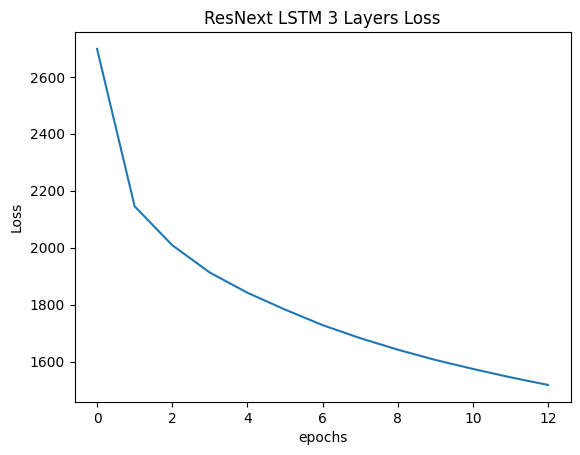

In [6]:
plt.title("ResNext LSTM 3 Layers Loss")
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [7]:
# Using epoch=9
checkpoint = torch.load('./ResNextCNNtoRNNSingleLayer.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNNtoRNN(
  (encoder): EncoderCNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (rel

In [9]:
vocab = test_dataset.caption_vocab.to(device)
results = []

for idx, (img_label, img, caption) in enumerate(test_dataset):
    sample_img = img.to(device)
    sample_img_label = img_label
    sample_img_caption = caption
    generated_caption = model.caption_image(sample_img, vocab)
    result = {
        'img_label': img_label,
        'img': img.T,
        'target_caption': [vocab.lookup_token(token) for token in caption],
        'generated_caption': generated_caption
    }
    results.append(result)
    
    if idx == 100:
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE LABEL: ./flickr8/Images/1015584366_dfcec3c85a.jpg
TARGET CAPTION: ['<bos>', 'The', 'black', 'dog', 'jumped', 'the', 'tree', 'stump', '.', '\n', '<eos>']
GENERATED CAPTION: ['<bos>', 'A', 'dog', 'is', 'running', 'through', 'the', 'grass', '.', '\n', '<eos>']


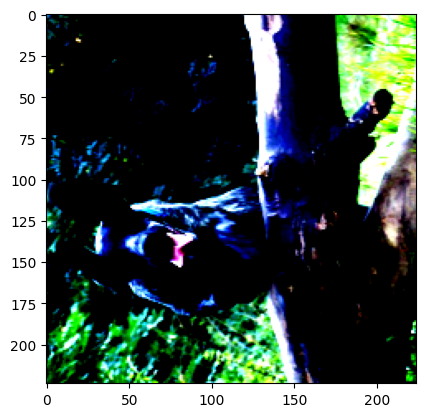

In [10]:
SAMPLE_IDX = 9

plt.imshow(results[SAMPLE_IDX]['img'])
print(f"IMAGE LABEL: {results[SAMPLE_IDX]['img_label']}")
print(f"TARGET CAPTION: {results[SAMPLE_IDX]['target_caption']}")
print(f"GENERATED CAPTION: {results[SAMPLE_IDX]['generated_caption']}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE LABEL: ./flickr8/Images/1077546505_a4f6c4daa9.jpg
TARGET CAPTION: ['<bos>', 'A', 'child', 'is', 'falling', 'off', 'a', 'slide', 'onto', 'colored', 'balloons', 'floating', 'on', 'a', 'pool', 'of', 'water', '.', '\n', '<eos>']
GENERATED CAPTION: ['<bos>', 'A', 'child', 'in', 'a', 'blue', 'shirt', 'is', 'jumping', 'into', 'a', 'pool', '.', '\n', '<eos>']


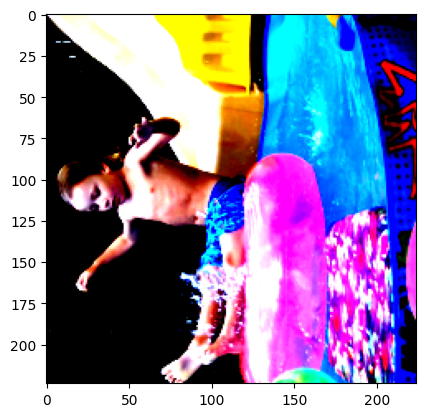

In [11]:
SAMPLE_IDX = 59

plt.imshow(results[SAMPLE_IDX]['img'])
print(f"IMAGE LABEL: {results[SAMPLE_IDX]['img_label']}")
print(f"TARGET CAPTION: {results[SAMPLE_IDX]['target_caption']}")
print(f"GENERATED CAPTION: {results[SAMPLE_IDX]['generated_caption']}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE LABEL: ./flickr8/Images/1107471216_4336c9b328.jpg
TARGET CAPTION: ['<bos>', 'There', 'is', 'a', 'kid', 'with', 'a', 'gun', '.', '\n', '<eos>']
GENERATED CAPTION: ['<bos>', 'A', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'is', 'sitting', 'on', 'a', 'bench', '.', '\n', '<eos>']


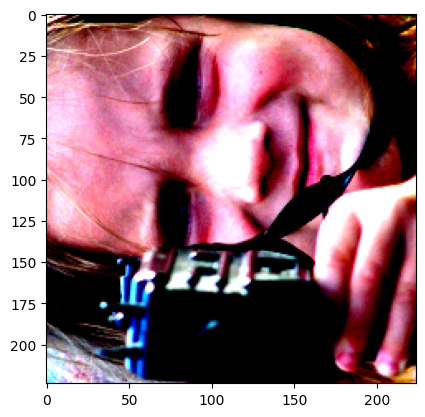

In [15]:
SAMPLE_IDX = 99

plt.imshow(results[SAMPLE_IDX]['img'])
print(f"IMAGE LABEL: {results[SAMPLE_IDX]['img_label']}")
print(f"TARGET CAPTION: {results[SAMPLE_IDX]['target_caption']}")
print(f"GENERATED CAPTION: {results[SAMPLE_IDX]['generated_caption']}")
